In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/120dog breeds-224.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset224')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset224/120dog breeds-224')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 224

In [ ]:
# datagen = ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input, validation_split=0.2)
# train_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='training',
#                         x_col='id',
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))

# validation_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='validation',
#                         x_col='id', 
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))


train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='training',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

validation_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input, 
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='validation',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    color_mode='rgb',
    target_size=(img_size, img_size)
)


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in resnet50.layers:
    layer.trainable=False

model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              #loss='SparseSoftmaxCrossEntropyWithLogits',
              #loss='SparseSoftmaxCrossEntropyWithLogits',
              metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                         

In [ ]:
# history_res = model.fit(train_generator, epochs=50, verbose = 1,
#                        validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Resnet50Newversion1.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_res = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
512/512 [==============================] - 137s 235ms/step - loss: 4.2268 - accuracy: 0.1148 - val_loss: 2.7426 - val_accuracy: 0.4887
Epoch 2/50
512/512 [==============================] - 117s 228ms/step - loss: 2.9982 - accuracy: 0.3205 - val_loss: 1.6271 - val_accuracy: 0.6404
Epoch 3/50
512/512 [==============================] - 116s 226ms/step - loss: 2.3745 - accuracy: 0.4243 - val_loss: 1.1937 - val_accuracy: 0.6972
Epoch 4/50
512/512 [==============================] - 116s 226ms/step - loss: 2.0798 - accuracy: 0.4714 - val_loss: 1.0472 - val_accuracy: 0.7030
Epoch 5/50
512/512 [==============================] - 118s 231ms/step - loss: 1.8871 - accuracy: 0.5051 - val_loss: 0.9336 - val_accuracy: 0.7363
Epoch 6/50
512/512 [==============================] - 116s 226ms/step - loss: 1.7818 - accuracy: 0.5207 - val_loss: 0.9002 - val_accuracy: 0.7290
Epoch 7/50
512/512 [==============================] - 115s 225ms/step - loss: 1.6998 - accuracy: 0.5367 - val_loss: 0.8600 -

In [ ]:
model.save('/content/drive/MyDrive/Resnet50Newversion1')

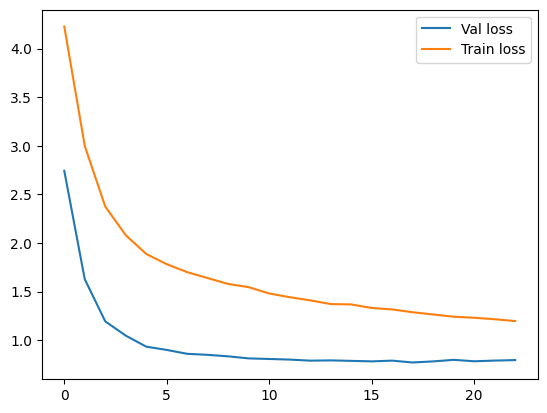

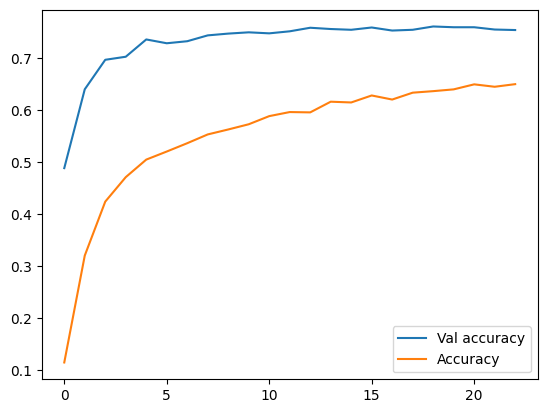

In [ ]:
plt.figure()
plt.plot(history_res .history['val_loss'], label = 'Val loss')
plt.plot(history_res .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_res .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_res .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()